In [8]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor as pt
import seaborn as sns
from packaging import version

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [11]:
assert version.parse(pm.__version__) >= version.parse("5.8.0")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.9.0


In [12]:
# import the new functionality
from pymc import do, observe

# Google ad spend on sales revenue confounded by TV ads
See Thomas Weicki PyMCon web series
https://www.pymc-labs.com/blog-posts/causal-analysis-with-pymc-answering-what-if-with-the-new-do-operator/

In [5]:
RANDOM_SEED = 271827
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

/home/mrosinski/mambaforge/envs/pymc_env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/mrosinski/mambaforge/envs/pymc_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


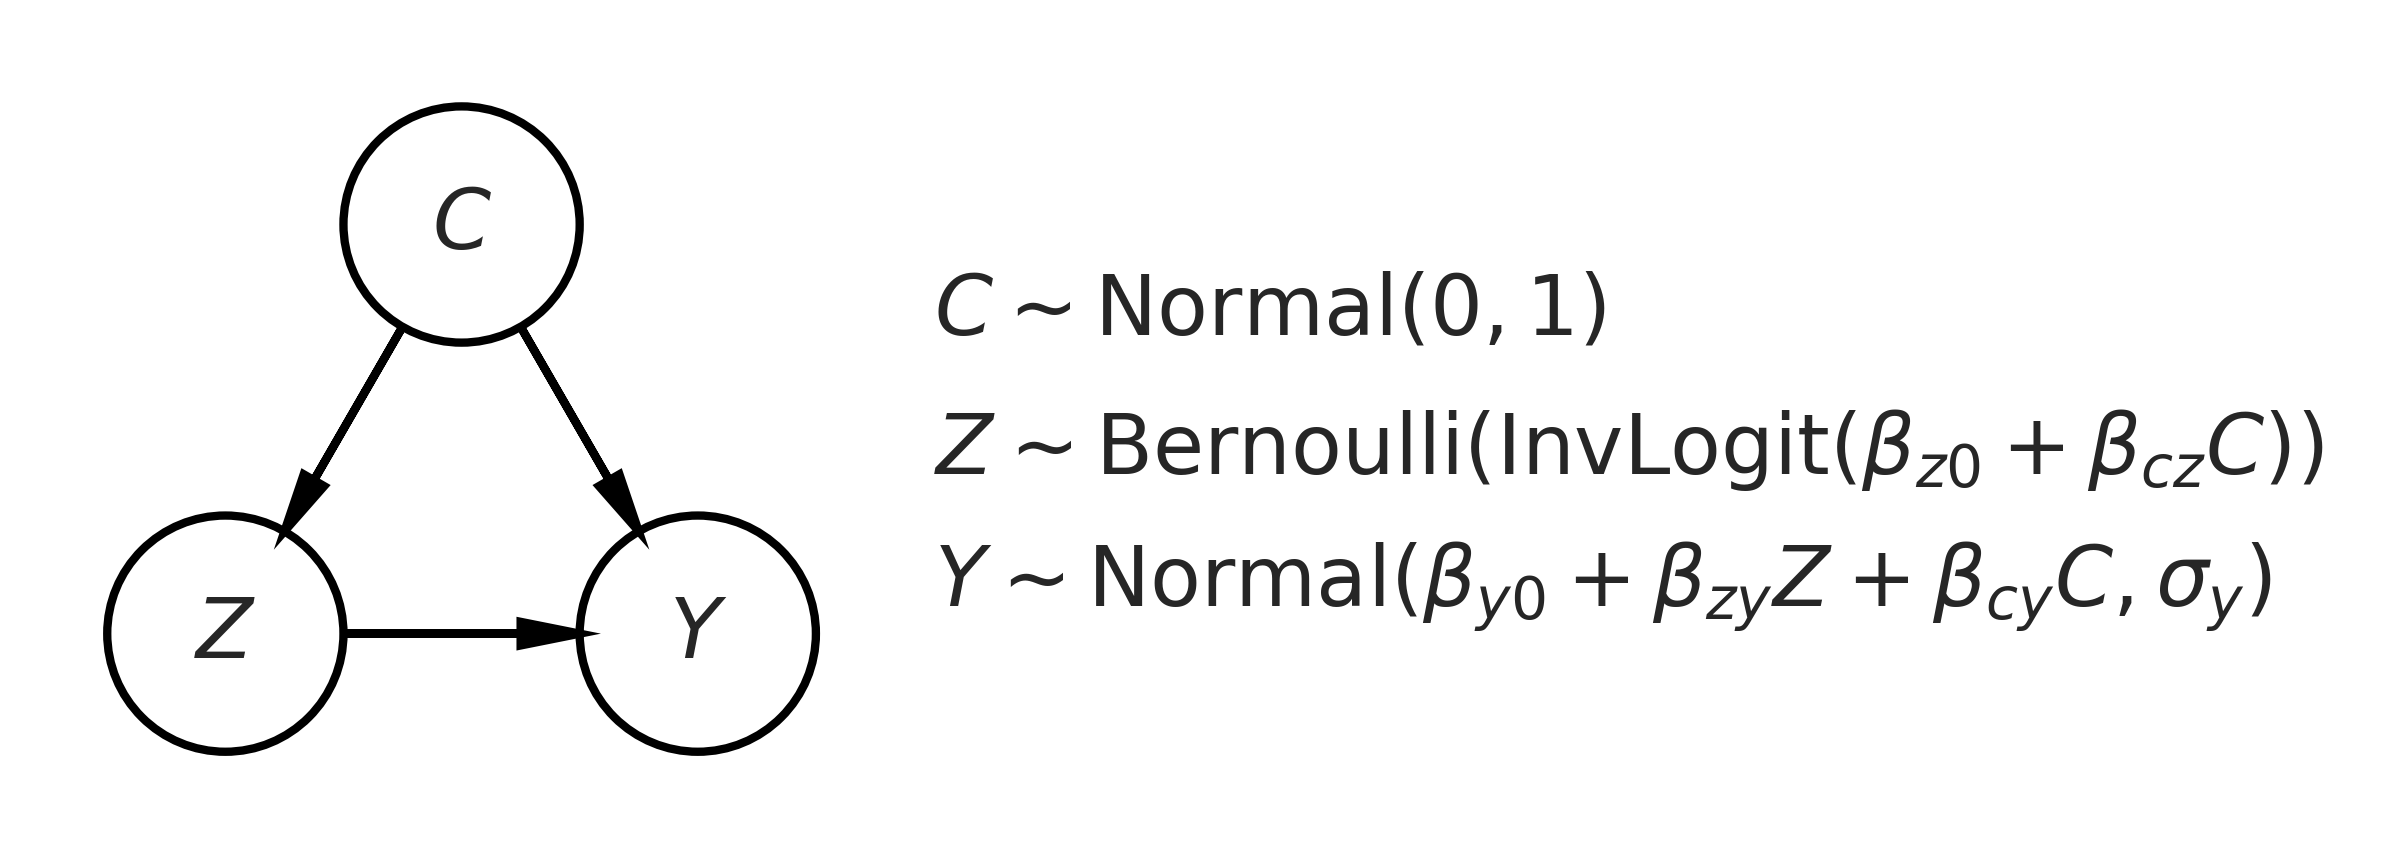

In [39]:
pgm = daft.PGM()
pgm.add_node("y", "$Y$", 0, 0)
pgm.add_node("z", "$Z$", -1, 0)
pgm.add_node("c", "$C$", -0.5, 0.866)
pgm.add_edge("z", "y")
pgm.add_edge("c", "y")
pgm.add_edge("c", "z")
pgm.add_text(0.5, 0.6, r"$C \sim \mathrm{Normal}(0, 1)$")
pgm.add_text(
    0.5,
    0.3,
    r"$Z \sim \mathrm{Bernoulli}(\operatorname{InvLogit}(\beta_{z0} + \beta_{cz} C))$",
)
pgm.add_text(
    0.5,
    0,
    r"$Y \sim \mathrm{Normal}(\beta_{y0} + \beta_{zy} Z + \beta_{cy} C, \sigma_y)$",
)
pgm.render(dpi=300);

# Create data generating process that has a causal structure

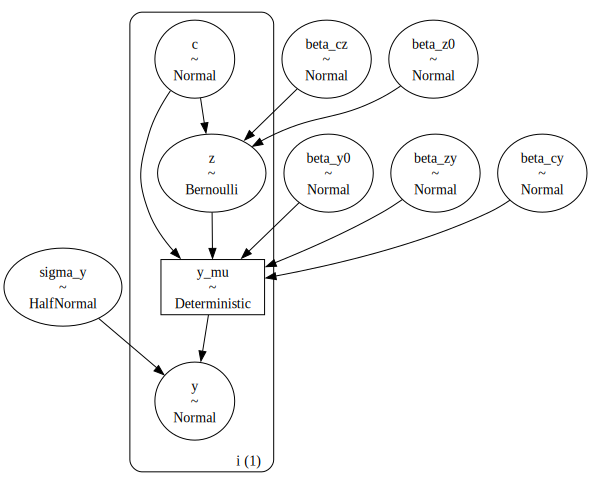

In [13]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on Y <- C -> Z
    beta_y0 = pm.Normal("beta_y0")
    beta_cy = pm.Normal("beta_cy")
    beta_cz = pm.Normal("beta_cz")
    # priors on Z -> Y causal path
    beta_z0 = pm.Normal("beta_z0")
    beta_zy = pm.Normal("beta_zy")
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    z = pm.Bernoulli("z", p=pm.invlogit(beta_z0 + beta_cz * c), dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_zy * z) + (beta_cy * c), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")

pm.model_to_graphviz(model_generative)

In [15]:
# Assume an average treatment effect (ATE) that Google ads have no treatment effect
true_ATE = 0.0

true_values = {
    "beta_z0": 0.0,
    "beta_y0": 0.0,
    "beta_cz": 1.5,
    "beta_zy": true_ATE,
    "beta_cy": 1.0,
    "sigma_y": 0.2,
}

model_simulate = do(model_generative, true_values)

# Forward sampling to generate data

In [25]:
N = 1000

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=RANDOM_SEED)

observed = {
    "c": simulate.prior["c"].values.flatten(),
    "y": simulate.prior["y"].values.flatten(),
    "z": simulate.prior["z"].values.flatten(),
}

df = pd.DataFrame(observed).sort_values("c", ascending=False)
df.shape

Sampling: [c, y, z]


(1000, 3)

In [26]:
df.head()

,c,y,z
966,3.823146,3.730616,1
510,3.159657,2.832098,0
764,3.098754,3.355861,1
217,3.029300,3.211918,1
747,2.874763,3.058441,1


/home/mrosinski/mambaforge/envs/pymc_env/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


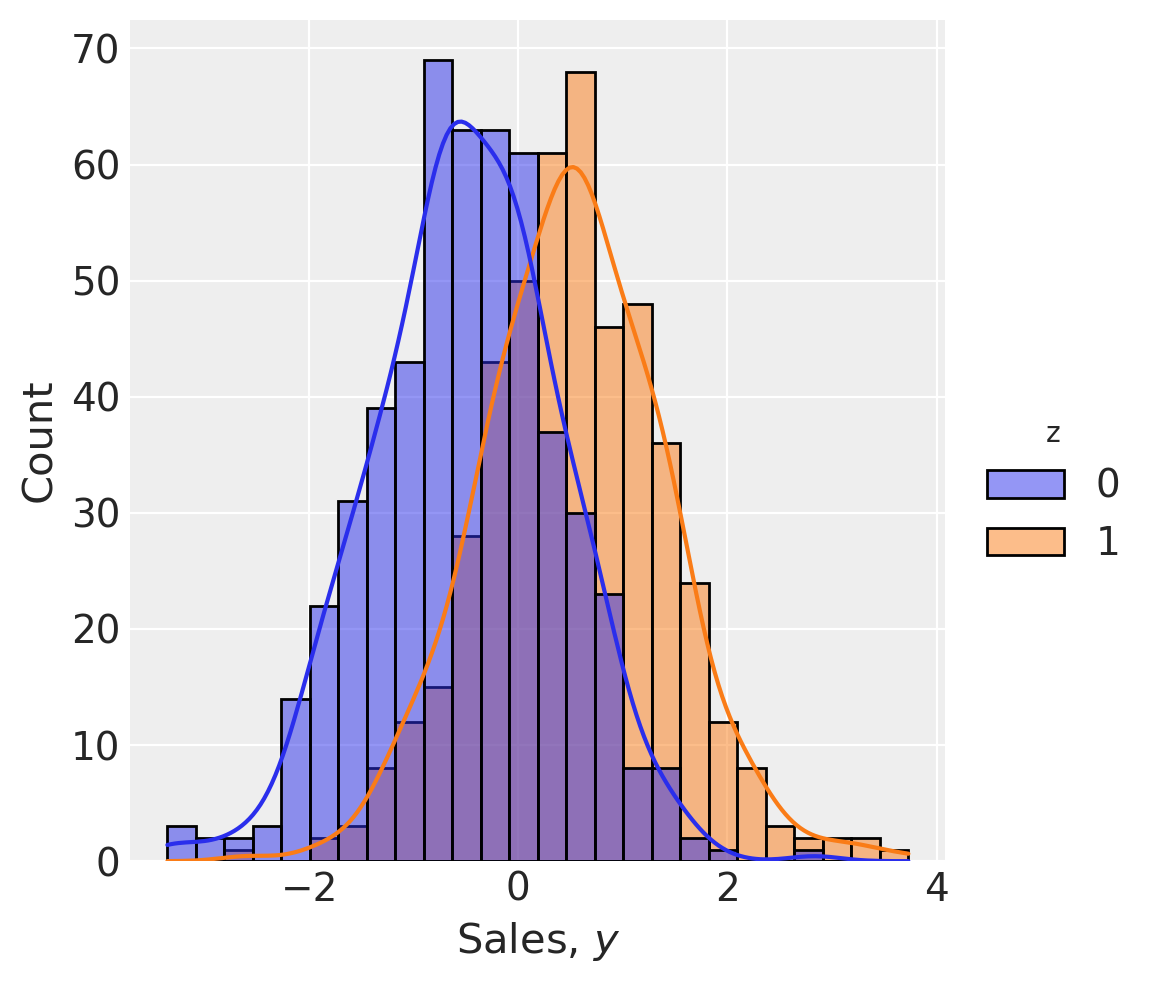

In [27]:
ax = sns.displot(data=df, x="y", hue="z", kde=True)
ax.set(xlabel="Sales, $y$");

In [28]:
# N = 5_000
# Q = rng.normal(size = N)
# X = rng.normal(loc = 0.314 * Q, scale = 0.69, size = N)
# Y = rng.normal(loc = 0.81 * X + 0.17 * Q, scale = 0.3, size = N)
# P = rng.normal(loc = 0.42 * X + 0.63 * Y, scale = 0.2, size = N)
# df = pd.DataFrame({"Q": Q, "X": X, "Y": Y, "P": P})
# df.head()

# Infering model parameters
Combine blank generative model with data.
We want to derive this observed model from our original "empty" model_generative from above, so that no parameters are fixed in place.

In [29]:
# new function called observe(). 
# This function takes a model and data, and returns a new model with the data set as
# observed on our target RV, similar to the do() function.
    
model_inference = observe(model_generative, {"c": df["c"], "y": df["y"], "z": df["z"]})
model_inference.set_dim("i", N, coord_values=np.arange(N))

In [30]:
with model_inference:
    idata = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_y0, beta_cy, beta_cz, beta_z0, beta_zy, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


# Plot posterior distributions
By plotting the known parameter values we used to generate the simulated data, we can confirm that the inference step has done a reasonable job of estimating credible intervals for these values.

/tmp/ipykernel_1526/2389791052.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


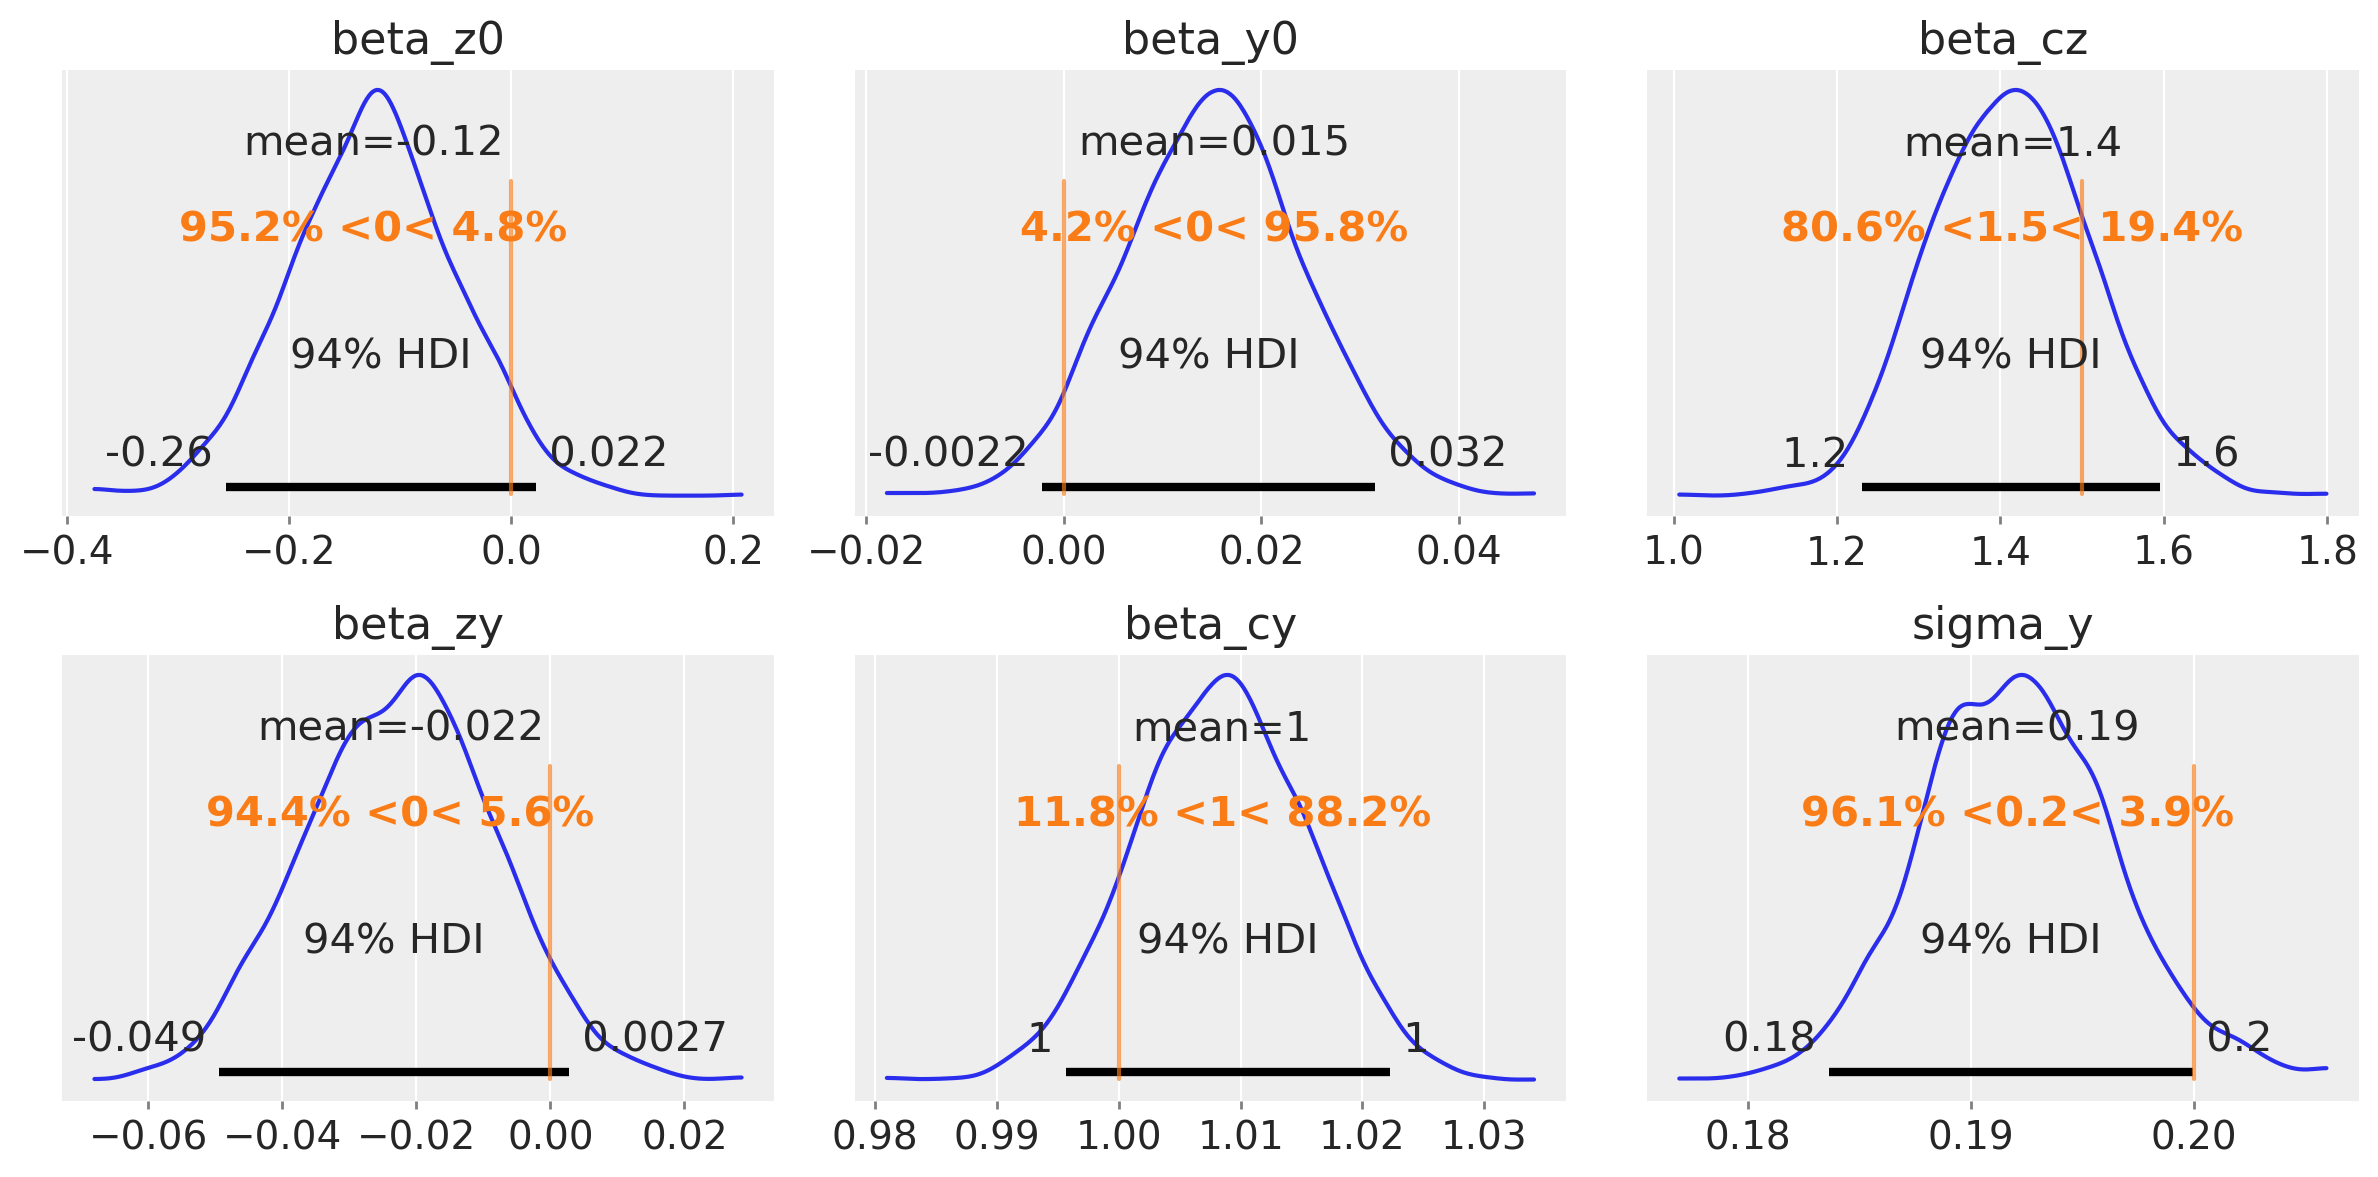

In [31]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 6),
)
plt.tight_layout();

# Bayesian causal inference
We can now perform counterfactual reasoning. 
This is where we're asking "What if?": 
- What if we stopped Google ads?
- What if we increased spending on Google ads?
- What would we expect our data to look like in these scenarios?

Critically, these hypothetical interventions remove any influence of TV on Google Ads, because the assumption is that we turn Google Ads on and off irrespective of what TV is doing. This is the logic behind the do operator.

In [32]:
# Replace c with its observed values
model_counterfactual = do(model_inference, {"c": df["c"]})

Now we are able to use the do() operator to set all the values of Z to either 0 or 1 to calculate

In [33]:
# Generate models with Z=0 and Z=1
model_z0 = do(model_counterfactual, {"z": np.zeros(N, dtype="int32")}, prune_vars=True)
model_z1 = do(model_counterfactual, {"z": np.ones(N, dtype="int32")}, prune_vars=True)

In [36]:
# Sample new sales data assuming Google Ads off: P(Y | c, do(z=0))
idata_z0 = pm.sample_posterior_predictive(
    idata,
    model=model_z0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=RANDOM_SEED,
)
# Sample new sales data assuming Google Ads on: P(Y | c, do(z=1))
idata_z1 = pm.sample_posterior_predictive(
    idata,
    model=model_z1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=RANDOM_SEED,
)

Sampling: []


Sampling: []


In [37]:
# calculate estimated ATE
ATE_est = idata_z1.predictions - idata_z0.predictions
print(f"Estimated ATE = {ATE_est.y_mu.mean().values:.2f}")

Estimated ATE = -0.02


In [40]:
def plot_causal_estimates(models, ATE_est, model_names):
    """Utility plot function to generate figure for estimated outcomes and causal effects."""
    fig, ax = plt.subplots(1, 2)

    # left plot of estimated outcomes
    ret = az.plot_forest(
        [models[0].predictions, models[1].predictions],
        combined=True,
        ax=ax[0],
        model_names=model_names,
    )
    # remove alternate row shading
    for p in ret[0].patches:
        p.set_color("white")

    # right plot of estimated ATE
    az.plot_posterior(
        idata, var_names="beta_zy", ref_val=true_ATE, round_to=4, ax=ax[1]
    )

    # formatting
    ax[0].set(
        title="Estimated outcomes under intervention",
        ylabel="unit, $i$ (ordered)",
        yticklabels=[],
    )
    ax[1].set(title="Average Treatment Effect")
    plt.tight_layout()

    plt.suptitle(
        "Unit level estimates with do operation,\nand estimate of Average Treatment Effect",
        y=1.05,
    );

/tmp/ipykernel_1526/3505337537.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


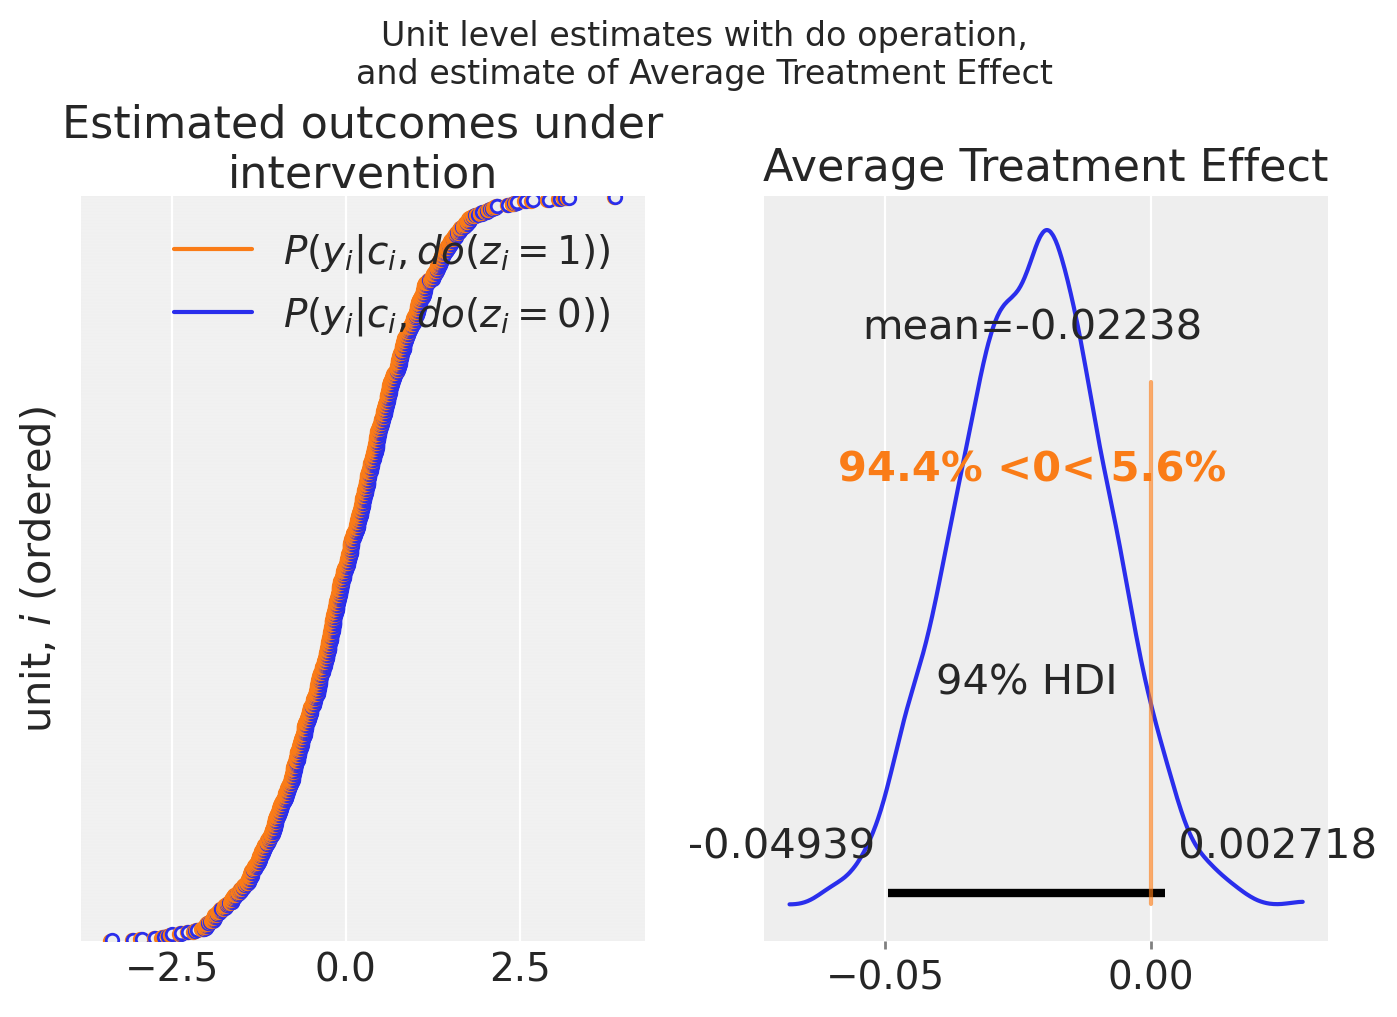

In [41]:
plot_causal_estimates(
    [idata_z0, idata_z1],
    ATE_est,
    model_names=[r"$P(y_i|c_i,do(z_i=0))$", r"$P(y_i|c_i,do(z_i=1))$"],
)

In [38]:
percent = (idata.posterior["beta_zy"] / idata.posterior["beta_cy"]) * 100
print(
    f"Causal effect of Google Ads on sales is {percent.mean():.1f}% [{az.hdi(percent).x.data[0]:.1f}%,{az.hdi(percent).x.data[1]:.1f}%] of the effect of TV on sales"
)

Causal effect of Google Ads on sales is -2.2% [-4.7%,0.4%] of the effect of TV on sales


In [42]:
# with pm.Model():
#     # priors on y <- c -> z
#     beta_c = pm.Normal("beta_c", shape=3)
#     # priors on z -> y causal path
#     beta_z = pm.Normal("beta_z", shape=2)
#     # observational noise on y
#     sigma_y = pm.HalfNormal("sigma_y")
#     # core nodes and causal relationships
#     c = pm.Normal("c", mu=0, sigma=1, observed=tv_spend)
#     z = pm.Bernoulli("z", p=pm.invlogit(beta_z[0] + beta_z[1] * c),
#                     observed = search_spend)
#     y_mu = pm.Deterministic("y_mu", beta_c[0] + (beta_c[1] * z) + (beta_c[2] * c ))
#     y = pm.Normal("y", mu=y_mu, sigma=sigma_y, observed=)